<a href="https://colab.research.google.com/github/skhabiri/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/skhabiri_LS_DS_build2_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [198]:
import pandas as pd
import numpy as np
!pip install category_encoders==2.*


data = pd.read_csv('https://github.com/skhabiri/Forest_cover_type_data/raw/master/train.csv')
print(data.shape)
data.head()


(15120, 56)


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [199]:
data.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [200]:
data.nunique().sort_values(ascending=False)

Id                                    15120
Horizontal_Distance_To_Roadways        3250
Horizontal_Distance_To_Fire_Points     2710
Elevation                              1665
Vertical_Distance_To_Hydrology          423
Horizontal_Distance_To_Hydrology        400
Aspect                                  361
Hillshade_3pm                           247
Hillshade_9am                           176
Hillshade_Noon                          141
Slope                                    52
Cover_Type                                7
Soil_Type29                               2
Soil_Type28                               2
Soil_Type5                                2
Soil_Type4                                2
Soil_Type3                                2
Soil_Type2                                2
Soil_Type1                                2
Wilderness_Area4                          2
Wilderness_Area3                          2
Wilderness_Area2                          2
Wilderness_Area1                

In [201]:
# pd.Series({c: data[c].unique() for c in data})[-40:]
# [data[col].unique() for col in data]

Our target label is "Cover_Type"
We will drop imb% imbalance low cardinal features. We also drop "id" column.

In [202]:
def wrangle_pre(X, imb=0.95):
  '''
  Returns the sorted list of feature names 
  with imbalance exceeding imb value
  '''
  X=X.copy()
  # drop the binary features with imb% imbalance
  # mask = X.nunique().sort_values(ascending=False) < 5
  # lowcard_col = X.nunique().sort_values(ascending=False)[mask].index

  mask2 = pd.Series({col: X[col].value_counts().
                     max()/X[col].value_counts().
                     sum() for col in X.nunique().index}).sort_values(ascending=False)
  
  mask2 = mask2[mask2 >= imb]

  Id_skew_cols = ["Id"] + list(mask2.index) 
  return Id_skew_cols

In [203]:
from sklearn.model_selection import train_test_split

# Split train into train & val
train, val = train_test_split(data, train_size=0.80, test_size=0.20, stratify=data["Cover_Type"], 
                                random_state=42)
print(f'train: {train.shape}, val: {val.shape}')


# Separate class label and data 
y_train = train["Cover_Type"]
X_train = train.drop("Cover_Type", axis=1)
y_val = val["Cover_Type"]
X_val = val.drop("Cover_Type", axis=1)

train: (12096, 56), val: (3024, 56)


In [204]:
Id_skew_cols = wrangle_pre(X_train, imb=0.01)

In [205]:
def wrangle(X, drop_count=1, cols=Id_skew_cols):
  '''
  drops drop_count number of features from col starting from index=0 (Id)
  '''  
  print("drop_count parameter: ",drop_count)
  X = X.copy()
  X = X.drop(labels=cols[:drop_count], axis=1)
  print(f'X shape before return: {X.shape}')
  return X


In [206]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, mean_absolute_error

import random 


### Baseline model

In [207]:
y_train.value_counts(normalize=True)

7    0.142857
6    0.142857
5    0.142857
4    0.142857
3    0.142857
2    0.142857
1    0.142857
Name: Cover_Type, dtype: float64

In [ ]:
# Instantiate
log_model = LogisticRegression()

# Fit with training data
log_model.fit(X_train, y_train)

print('training accuracy:', log_model.score(X_train, y_train))
print('validation accuracy:', log_model.score(X_val, y_val))

y_pred = log_model.predict(X_val)
print(classification_report(y_val, y_pred, target_names=None))

### Randomforestclassifier pipeline, and feature_importances_

In [ ]:
# max_depth = list()
# for tree in clf.estimators_:
#     max_depth.append(tree.tree_.max_depth)

# print("avg max depth %0.1f" % (sum(max_depth) / len(max_depth)))



In [208]:
print(f' X_train shape before pipeline: {X_train.shape}')

# Make pipeline!
pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    # ce.OrdinalEncoder(), 
    # SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=20, 
                           min_samples_split=2, min_samples_leaf=8, min_weight_fraction_leaf=0.0, 
                           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1, 
                           random_state=42, verbose=0, warm_start=False, class_weight=None, 
                           ccp_alpha=0.0, max_samples=None)
    )

drop_count = int(0.1*len(Id_skew_cols))
pipeline.set_params(functiontransformer__kw_args={'drop_count': drop_count})

#.fit: WITHOUT CHANGING X APPLIES THE TRANSFORM AND CHECK TO SEE IF y FITS TRANSFORMED OF X
print("\n fitting ...")
pipeline.fit(X_train, y_train)

print("\n getting X_train transformed column labels")
feat_name = pipeline.named_steps['functiontransformer'].transform(X_train).columns

print("X_train: ", len(X_train.columns), "X_fit: ", len(feat_name))
assert len(X_train.columns) == len(feat_name) + drop_count

print("\n predicting ...")
y_pred = pipeline.predict(X_val)

print("\n Accuracy ...")
print('Training Accuracy', accuracy_score(y_train, pipeline.predict(X_train)))
print('Validation Accuracy', accuracy_score(y_val, y_pred))

 X_train shape before pipeline: (12096, 55)

 fitting ...
drop_count parameter:  5
X shape before return: (12096, 50)

 getting X_train transformed column labels
drop_count parameter:  5
X shape before return: (12096, 50)
X_train:  55 X_fit:  50

 predicting ...
drop_count parameter:  5
X shape before return: (3024, 50)

 Accuracy ...
drop_count parameter:  5
X shape before return: (12096, 50)
Training Accuracy 0.9040178571428571
Validation Accuracy 0.8214285714285714


In [209]:
rf = pipeline.named_steps['randomforestclassifier']
print(pipeline.named_steps['randomforestclassifier'].n_features_)
importances = pd.Series(rf.feature_importances_, feat_name).sort_values(ascending=True)

50


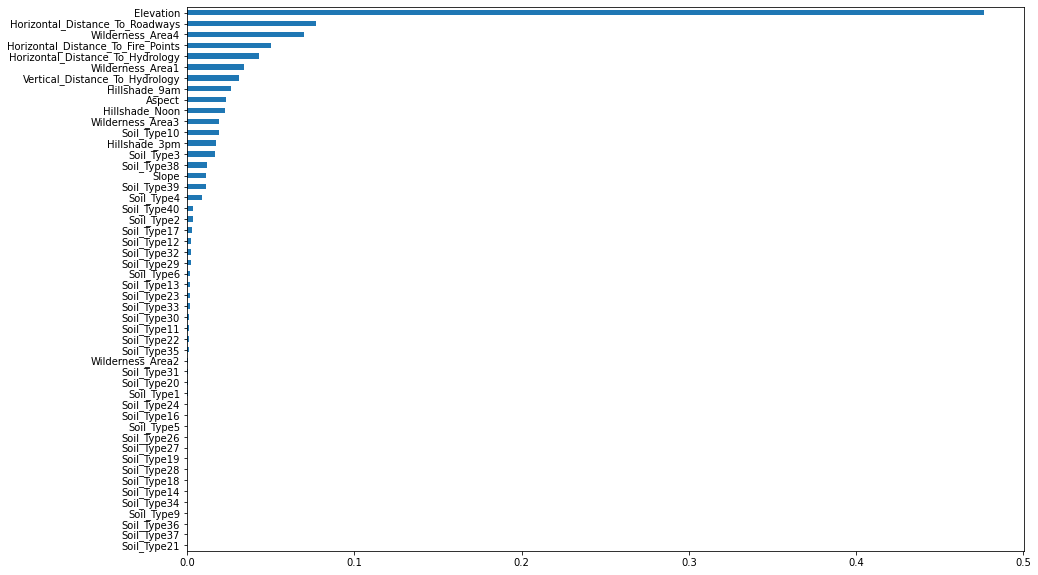

In [210]:
plt.figure(figsize=(15,10))
importances.plot.barh()

In the presence of all the features, feature_importance_ of Id column ranks relatively high. Hence, feature_importance_ by itself cannot be a deciding factor. We drop 10% of skewed columns to get 82% accuracy

### Cross Validation Curve for skewed features

val scores [[0.82231405 0.82596114 0.82389417 0.8222406  0.81893344]
 [0.80867769 0.8147995  0.81438611 0.81603969 0.80942538]
 [0.81528926 0.81438611 0.81397272 0.81025217 0.80611823]
 [0.81280992 0.81934684 0.81686647 0.80694502 0.8147995 ]
 [0.81942149 0.8218272  0.80777181 0.8147995  0.81273253]
 [0.80702479 0.81190575 0.81397272 0.80901199 0.80777181]
 [0.81404959 0.82306738 0.81562629 0.80239768 0.80487805]
 [0.81363636 0.81893344 0.80942538 0.81976023 0.80446465]
 [0.80950413 0.81852005 0.8147995  0.81066556 0.80198429]
 [0.8177686  0.81810666 0.8152129  0.81397272 0.80777181]
 [0.8107438  0.81438611 0.8081852  0.81107896 0.80198429]
 [0.81033058 0.81397272 0.81727987 0.81066556 0.79950393]
 [0.81942149 0.82100041 0.81686647 0.81149235 0.80859859]
 [0.81322314 0.80529144 0.81603969 0.81273253 0.80859859]
 [0.8177686  0.81231914 0.81231914 0.81149235 0.81314593]
 [0.81487603 0.8081852  0.81810666 0.81686647 0.80611823]
 [0.80371901 0.80198429 0.80942538 0.80694502 0.81149235]
 [0

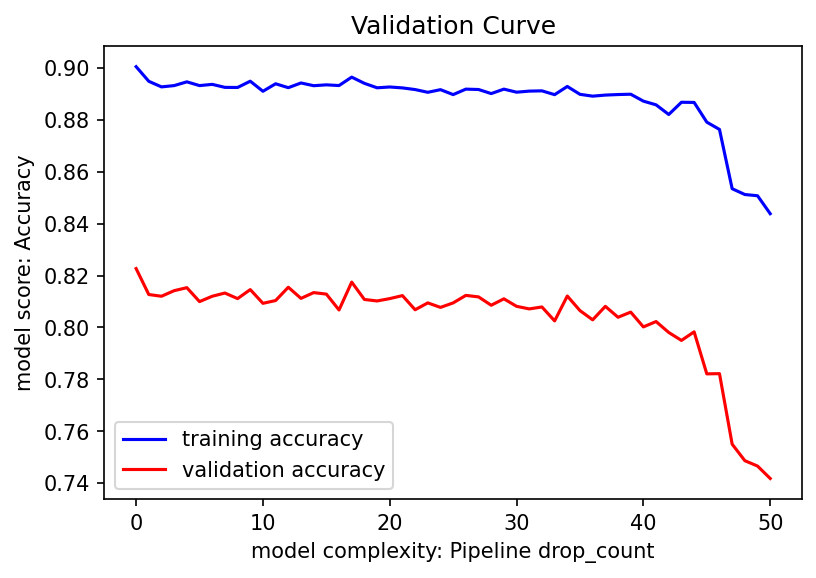

In [211]:
par_name = "drop_count"
param_range = [{par_name: i} for i in range(len(Id_skew_cols))]
param_rangex = [i for i in range(len(Id_skew_cols))]

# par_name = "max_features"
# param_range = np.arange(0.1,1.1,0.1)
# param_rangex = param_range
               
# par_name = "max_depth"
# param_range = range(1,25,1)
# param_rangex = param_range

# par_name = "min_samples_split"
# param_range = np.linspace(10, 0.01*len(X_train), 10, endpoint=True).astype(int)
# param_rangex = param_range

# par_name = "min_samples_leaf"
# param_range = np.linspace(2, 0.001*len(X_train), 10, endpoint=True).astype(int)
# param_rangex = param_range

# par_name = "criterion"
# param_range = ["gini", "entropy"]
# param_rangex = param_range


train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='functiontransformer__kw_args',
    # param_name='randomforestclassifier__'+ par_name, 
    
    param_range=param_range, 
    scoring='accuracy', 
    cv=5,
    n_jobs=-1
)
print("val scores", val_scores)
print("val scores mean", np.mean(val_scores, axis=1))

# Averaging CV scores
plt.figure(dpi=150)
plt.plot(param_rangex, np.mean(train_scores, axis=1), color='blue', label='training accuracy')
plt.plot(param_rangex, np.mean(val_scores, axis=1), color='red', label='validation accuracy')
plt.title('Validation Curve')
plt.xlabel(f'model complexity: Pipeline {par_name}')
plt.ylabel('model score: Accuracy')
plt.legend();

beyoun 30 features drop, validation accuracy starts going down.

### RandomizedSearchCV

In [212]:
# pipe = make_pipeline(FunctionTransformer(log_columns, ), PCA(), SVC())

# param_grid = dict(
#     functiontransformer__kw_args=[
#         {'col_idx': None},
#         {'col_idx': [1]}
#     ],
#     pca__n_components=[2, 5, 10],
#     svc__C=[0.1, 10, 100],
# )
# grid_search = GridSearchCV(pipe, param_grid=param_grid)

# digits = load_digits()
# res = grid_search.fit(digits.data, digits.target)      

In [215]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestclassifier'])

x_n_iter = 1000

param_distributions = {
    # 'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
     'functiontransformer__kw_args': [{par_name: i} for i in range(int(0.5*len(Id_skew_cols)))],
    'randomforestclassifier__min_samples_leaf': [random.randint(1, 1000) for i in range(20)], 
    'randomforestclassifier__min_samples_split': [random.randint(2, 1000) for i in range(20)], 
    'randomforestclassifier__max_features': [random.randint(2, 54) for i in range(20)], 
    'randomforestclassifier__criterion': ["gini", "entropy"]
    }

rscv = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=x_n_iter, 
    cv=4, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

rscv.fit(X_train, y_train)

bestpipe = rscv.best_estimator_
print('Cross-validation Accuracy', rscv.best_score_)
print('Best hyperparameters', rscv.best_params_)


Model Hyperparameters:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=20, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

drop_count parameter:  19
X shape before return: (12096, 36)
Cross-validation Accuracy 0.8098544973544973
Best hyperparameters {'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__max_features': 20, 'randomforestclassifier__criterion': 'entropy', 'functiontransformer__kw_args': {'drop_count': 19}}


In [218]:
rscv.best_estimator_

Pipeline(memory=None,
         steps=[('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function wrangle at 0x7f684cff1bf8>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args={'drop_count': 19},
                                     validate=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=20, max_features=20,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=8, min_samples_split=2,
                             

In [216]:
rscv.best_params_

{'functiontransformer__kw_args': {'drop_count': 19},
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_features': 20,
 'randomforestclassifier__min_samples_leaf': 8,
 'randomforestclassifier__min_samples_split': 2}

In [219]:
best_feat = bestpipe.named_steps['functiontransformer'].transform(X_train).columns
best_feat, best_feat.shape

drop_count parameter:  19
X shape before return: (12096, 36)


(Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
        'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
        'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
        'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
        'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
        'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type6',
        'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13',
        'Soil_Type14', 'Soil_Type17', 'Soil_Type22', 'Soil_Type23',
        'Soil_Type24', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
        'Soil_Type32', 'Soil_Type33', 'Soil_Type38', 'Soil_Type39',
        'Soil_Type40'],
       dtype='object'), (36,))

In [220]:
#.predict: WITHOUT ACTUALLY TRANSFORMING X, APPLIES THE TRANSFORMS TO X AND PREDICT a fitted y
# wrangle_col = pipeline.named_steps['functiontransformer'].transform(X_train).columns


print(f' X_val shape before predict : {X_val.shape}')
print("predicting ...")
y_pred = bestpipe.predict(X_val)
print(f' X_val shape after predict : {X_val.shape}')
print('Validation Accuracy', accuracy_score(y_val, y_pred))

 X_val shape before predict : (3024, 55)
predicting ...
drop_count parameter:  19
X shape before return: (3024, 36)
 X_val shape after predict : (3024, 55)
Validation Accuracy 0.8220899470899471
